# Automatic lightfield completion

Train a VAE on the images of a cross-shaped lightfield array to predict the diagonals

In [2]:
# Imports and data loading

import os
from dataloaders import hci4d
import numpy as np
import torch
from torch import nn, optim
import lightfield_vae as vae
from utils import show_scene, show_view_sequence
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.nn import functional as F

DATA_ROOT = os.path.join('data', 'SyntheticLightfieldData')
BATCH_SIZE = 1
use_cuda = torch.cuda.is_available()
print("Use cuda:", use_cuda)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_set = hci4d.HCI4D(os.path.join(DATA_ROOT, 'training'))
test_set = hci4d.HCI4D(os.path.join(DATA_ROOT, 'test'))
print("Training set length:", len(train_set))
print("Test set length:", len(test_set))

%load_ext autoreload
%autoreload 2

Use cuda: True
Training set length: 27
Test set length: 1


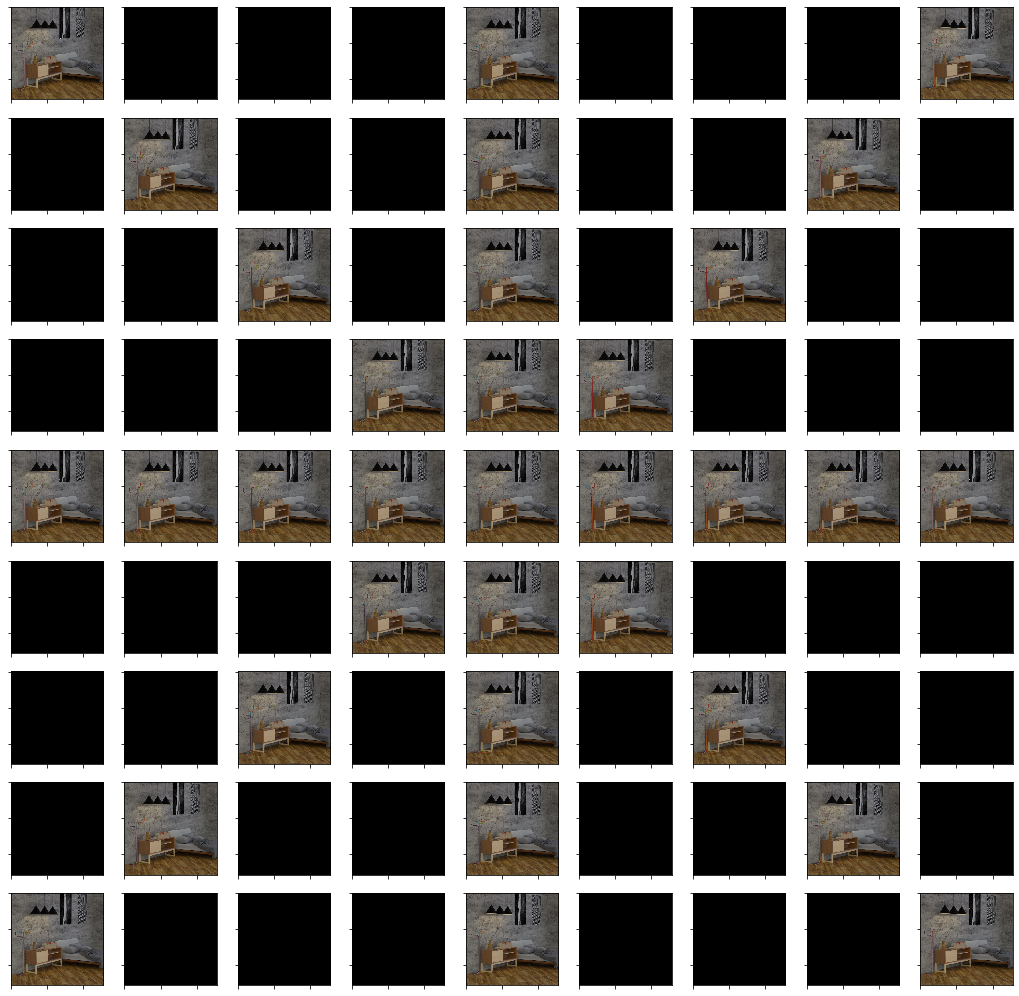

In [3]:
# Show an example image from the test set
show_scene(test_set.load_scene(0))

In [8]:
from main import train


Use cuda: True
Training set length: 27
Test set length: 1


RuntimeError: CUDA out of memory. Tried to allocate 1.95 GiB (GPU 0; 7.76 GiB total capacity; 5.10 GiB already allocated; 765.75 MiB free; 5.12 GiB reserved in total by PyTorch)

## Deprecated stuff
Just for testing purposes

In [5]:
# Load horizontal lightfield data
# TODO: How to handle different directions
from dataloaders.lightfield_loader import LightfieldLoader
train_loader = LightfieldLoader(train_set, scene_idx=0, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

print("Data samples for training:", len(train_loader.dataset))
print("Data samples for testing:", len(test_loader.dataset))

def train(epoch, log_interval=2):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        print(data.shape)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))




Data samples for training: 18
Data samples for testing: 1


In [6]:
for epoch in range(1, 11):
    train(epoch)


torch.Size([1, 3, 512, 512])
Train Epoch: 1 [0/18 (0%)]	Loss: 548389.250000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [2/18 (11%)]	Loss: 571614.937500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [4/18 (22%)]	Loss: 558215.312500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [6/18 (33%)]	Loss: 568328.000000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [8/18 (44%)]	Loss: 557154.937500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [10/18 (56%)]	Loss: 552877.250000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [12/18 (67%)]	Loss: 552080.062500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [14/18 (78%)]	Loss: 548491.812500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [16/18 (89%)]	Loss: 544222.187500
torch.Size([1, 3, 512, 512])
====> Epoch: 1 Average loss: 564956.9306
to

torch.Size([1, 3, 512, 512])
Train Epoch: 9 [4/18 (22%)]	Loss: 487121.406250
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [6/18 (33%)]	Loss: 489962.625000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [8/18 (44%)]	Loss: 488525.187500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [10/18 (56%)]	Loss: 489369.218750
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [12/18 (67%)]	Loss: 490747.687500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [14/18 (78%)]	Loss: 486408.906250
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [16/18 (89%)]	Loss: 487857.656250
torch.Size([1, 3, 512, 512])
====> Epoch: 9 Average loss: 488772.5017
torch.Size([1, 3, 512, 512])
Train Epoch: 10 [0/18 (0%)]	Loss: 487922.875000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 10 [2/18 (11%)]	Loss: 486008.843750
torch.Size([1, 3, 512, 512])


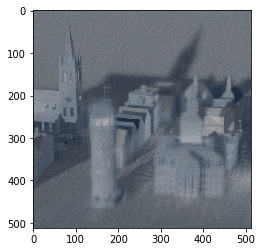

====> Test set loss: 527138.4653


In [7]:
from dataloaders.lightfield_loader import LightfieldLoader
test_loader = LightfieldLoader(test_set, scene_idx=0, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae.loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                img = recon_batch.view(BATCH_SIZE, 3, 512, 512)[0].cpu()
                img = np.stack((img[0], img[1], img[2]), axis=-1)
                plt.imshow(img)
                plt.show()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
test(0)